<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tayglobal/kinyu-demo/blob/master/notebooks/Sympy_and_Hedging.ipynb"><img src="https://files.tayglobal.com/images/icons/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tayglobal/kinyu-demo/blob/master/notebooks/Sympy_and_Hedging.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://files.tayglobal.com/blog/Sympy_and_Hedging.ipynb.html"><img src="https://files.tayglobal.com/images/icons/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Author: [Tony Yum](https://www.linkedin.com/in/tonyyum/)

# Sympy and hedging

In this notebook, we first play with Sympy and see what symbolic maths can do that
cannot be done with numerical methods. Next, using sympy we can calculate derivatives
of a function and we leverage that to work out the delta of an option. We then do some delta
hedging to see if the hedging cost indeed replicates the price of an option and get some
understanding regarding the process. 

## Imports

In [30]:
%matplotlib inline

import sympy as sy
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import pandas as pd
from datetime import datetime
from scipy.stats import norm
from sympy.stats import Normal, cdf

## Integration and infinity

First let's define an integration. The formula displays nicely in notebook.

In [31]:
x = sy.Symbol('x')
sy.Integral(sy.exp(-x), (x, 0, sy.oo))

Integral(exp(-x), (x, 0, oo))

Let's actually integrate the function with interval [0, ∞]

Using numerical integration, it will never get to 1.

In [32]:
sy.integrate(sy.exp(-x), (x, 0, sy.oo))

1

Let's just convince ourselves that the area under the function is around 1.

Blue line is the function and red box is the 1x1 square (even though it doesn't look square)

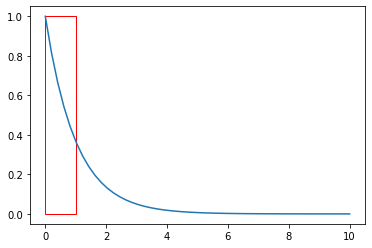

In [33]:
import matplotlib.patches as patches

x = np.linspace(0, 10)
y = np.exp(-x)

fig, ax = plt.subplots()
ax.plot(x, y)
rect = patches.Rectangle((0, 0), 1, 1,
                        linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

## Black Model

Here is the Black formula https://en.wikipedia.org/wiki/Black_model

I have taken the code from https://gist.github.com/raddy/bd0e977dc8437a4f8276

We now have Price as well as derivatives for put and call options.

In [34]:
#spot, strike, vol, days till expiry, interest rate, call or put (1,-1)
S, K, sigma, T, r,cp = sy.symbols('S,K,sigma,T,r,cp')

N = Normal('W', 0.0, 1.0)

d1 = (sy.ln(S / K) + (0.5 * sigma ** 2) * T) / (sigma * sy.sqrt(T))
d2 = d1 - sigma * sy.sqrt(T)

tv = sy.exp(-r * T) * (cp *S * cdf(N)(cp*d1) - cp * K  * cdf(N)(cp*d2))

bs_tv = sy.lambdify((S, K, sigma, T, r,cp),tv)

#1st Order Greeks
delta = sy.lambdify((S, K, sigma, T, r,cp),tv.diff(S))
vega = sy.lambdify((S, K, sigma, T, r,cp),tv.diff(sigma)/100.) #WATCH UNITS
theta = sy.lambdify((S, K, sigma, T, r,cp),tv.diff(T))
rho = sy.lambdify((S, K, sigma, T, r,cp),tv.diff(r))

#2nd Order Greeks
gamma = sy.lambdify((S, K, sigma, T, r,cp),tv.diff(S,S))
vanna = sy.lambdify((S, K, sigma, T, r,cp),tv.diff(S,sigma)/100.)
vomma = sy.lambdify((S, K, sigma, T, r,cp),tv.diff(sigma,sigma)/1e4) #IN TICKS
charm = sy.lambdify((S, K, sigma, T, r,cp),tv.diff(S,T)) #DELTA DECAY

#3rd Order -- Who cares about anything about dGamma?
speed = sy.lambdify((S, K, sigma, T, r,cp),tv.diff(S,3))

Again we can display those formulas

In [35]:
d1

(0.5*T*sigma**2 + log(S/K))/(sqrt(T)*sigma)

In [36]:
d2

-sqrt(T)*sigma + (0.5*T*sigma**2 + log(S/K))/(sqrt(T)*sigma)

In [37]:
tv

(-K*cp*(erf(0.5*sqrt(2)*cp*(-sqrt(T)*sigma + (0.5*T*sigma**2 + log(S/K))/(sqrt(T)*sigma)))/2 + 1/2) + S*cp*(erf(0.5*sqrt(2)*cp*(0.5*T*sigma**2 + log(S/K))/(sqrt(T)*sigma))/2 + 1/2))*exp(-T*r)

In [38]:
tv.diff(S)

(-0.5*sqrt(2)*K*cp**2*exp(-0.5*cp**2*(-sqrt(T)*sigma + (0.5*T*sigma**2 + log(S/K))/(sqrt(T)*sigma))**2)/(sqrt(pi)*S*sqrt(T)*sigma) + cp*(erf(0.5*sqrt(2)*cp*(0.5*T*sigma**2 + log(S/K))/(sqrt(T)*sigma))/2 + 1/2) + 0.5*sqrt(2)*cp**2*exp(-0.5*cp**2*(0.5*T*sigma**2 + log(S/K))**2/(T*sigma**2))/(sqrt(pi)*sqrt(T)*sigma))*exp(-T*r)

## Visualising Black Model

### Difference expiration date

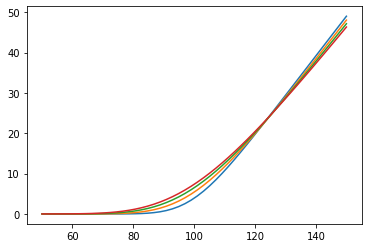

In [39]:
x = np.linspace(50, 150)
y = [bs_tv(s, 100, 0.1, 1, 0.02, 1) for s in x]
plt.plot(x, y)
y = [bs_tv(s, 100, 0.1, 2, 0.02, 1) for s in x]
plt.plot(x, y)
y = [bs_tv(s, 100, 0.1, 3, 0.02, 1) for s in x]
plt.plot(x, y)
y = [bs_tv(s, 100, 0.1, 4, 0.02, 1) for s in x]
plt.plot(x, y)

### First order derivatives

<lambdifygenerated-14>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (-r*(-K*cp*((1/2)*erf(0.5*sqrt(2)*cp*(-sqrt(T)*sigma + (0.5*T*sigma**2 + log(S/K))/(sqrt(T)*sigma))) + 1/2) + S*cp*((1/2)*erf(0.5*sqrt(2)*cp*(0.5*T*sigma**2 + log(S/K))/(sqrt(T)*sigma)) + 1/2))*exp(-T*r) + (0.25*sqrt(2)*K*cp**2*(0.5*T*sigma**2 + log(S/K))*exp(-0.5*cp**2*(-sqrt(T)*sigma + (0.5*T*sigma**2 + log(S/K))/(sqrt(T)*sigma))**2)/(sqrt(pi)*T**(3/2)*sigma) + S*cp*(0.25*sqrt(2)*cp*sigma/sqrt(T) - 0.25*sqrt(2)*cp*(0.5*T*sigma**2 + log(S/K))/(T**(3/2)*sigma))*exp(-0.5*cp**2*(0.5*T*sigma**2 + log(S/K))**2/(T*sigma**2))/sqrt(pi))*exp(-T*r))
<lambdifygenerated-14>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return (-r*(-K*cp*((1/2)*erf(0.5*sqrt(2)*cp*(-sqrt(T)*sigma + (0.5*T*sigma**2 + log(S/K))/(sqrt(T)*sigma))) + 1/2) + S*cp*((1/2)*erf(0.5*sqrt(2)*cp*(0.5*T*sigma**2 + log(S/K))/(sqrt(T)*sigma)) + 1/2))*exp(-T*r) + (0.25*sqrt(2)*K*cp**2*(0.5*T*sigma**2 + log(S/K))*exp(-0

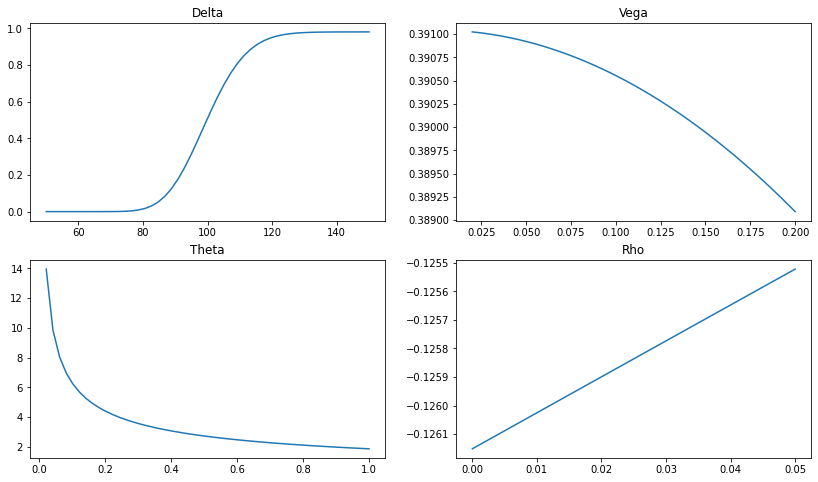

In [40]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(14, 8)

x = np.linspace(50, 150)
y = [delta(a, 100, 0.1, 1, 0.02, 1) for a in x]
ax = axs[0, 0]
ax.plot(x, y)
ax.title.set_text('Delta')

x = np.linspace(0.02, 0.2)
y = [vega(100, 100, a, 1, 0.02, 1) for a in x]
ax = axs[0, 1]
ax.plot(x, y)
ax.title.set_text('Vega')

x = np.linspace(0, 1)
y = [theta(100, 100, 0.1, a, 0.02, 1) for a in x]
ax = axs[1, 0]
ax.plot(x, y)
ax.title.set_text('Theta')

x = np.linspace(0, 0.05)
y = [rho(100, 100, 0.1, 0.1, a, 1) for a in x]
ax = axs[1, 1]
ax.plot(x, y)
ax.title.set_text('Rho')

### Second order derivatives

<lambdifygenerated-18>:2: RuntimeWarning: invalid value encountered in double_scalars
  return (-0.0001*sqrt(2)*cp**2*(-0.5*K*sqrt(T)*exp(-0.5*cp**2*(sqrt(T)*sigma - (0.5*T*sigma**2 + log(S/K))/(sqrt(T)*sigma))**2) + 0.5*K*cp**2*(sqrt(T)*sigma - (0.5*T*sigma**2 + log(S/K))/(sqrt(T)*sigma))*(0.5*T*sigma**2 + log(S/K))**2*exp(-0.5*cp**2*(sqrt(T)*sigma - (0.5*T*sigma**2 + log(S/K))/(sqrt(T)*sigma))**2)/(T*sigma**3) + 1.0*K*(0.5*T*sigma**2 + log(S/K))*exp(-0.5*cp**2*(sqrt(T)*sigma - (0.5*T*sigma**2 + log(S/K))/(sqrt(T)*sigma))**2)/(sqrt(T)*sigma**2) + 0.5*S*cp**2*(1 - (0.5*T*sigma**2 + log(S/K))/(T*sigma**2))*(sqrt(T) - (0.5*T*sigma**2 + log(S/K))/(sqrt(T)*sigma**2))*(0.5*T*sigma**2 + log(S/K))*exp(-0.5*cp**2*(0.5*T*sigma**2 + log(S/K))**2/(T*sigma**2)) + S*(0.5*sqrt(T) - (0.5*T*sigma**2 + 1.0*log(S/K))/(sqrt(T)*sigma**2))*exp(-0.5*cp**2*(0.5*T*sigma**2 + log(S/K))**2/(T*sigma**2)))*exp(-T*r)/(sqrt(pi)*sigma))


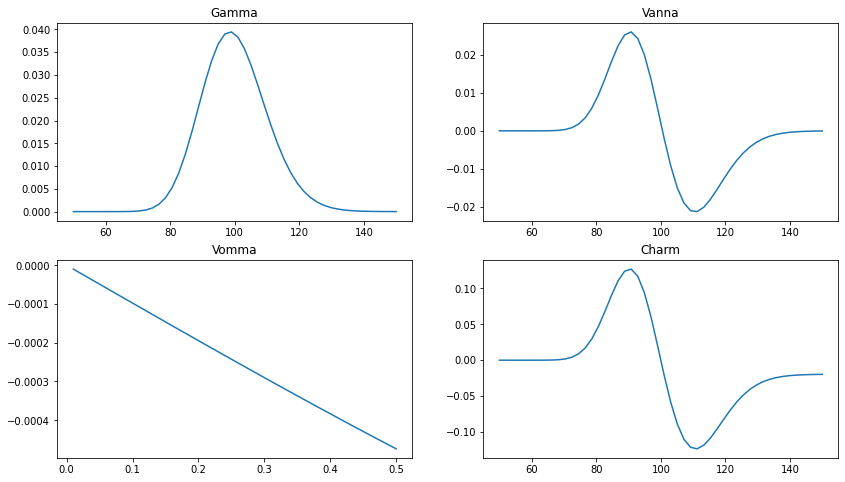

In [41]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(14, 8)

x = np.linspace(50, 150)
y = [gamma(a, 100, 0.1, 1, 0.02, 1) for a in x]
ax = axs[0, 0]
ax.plot(x, y)
ax.title.set_text('Gamma')

x = np.linspace(50, 150)
y = [vanna(a, 100, 0.1, 1, 0.02, 1) for a in x]
ax = axs[0, 1]
ax.plot(x, y)
ax.title.set_text('Vanna')

x = np.linspace(0, 0.5)
y = [vomma(100, 100, a, 1, 0.02, 1) for a in x]
ax = axs[1, 0]
ax.plot(x, y)
ax.title.set_text('Vomma')

x = np.linspace(50, 150)
y = [charm(a, 100, 0.1, 1, 0.02, 1) for a in x]
ax = axs[1, 1]
ax.plot(x, y)
ax.title.set_text('Charm')

## Heding Portfolio

Let's say we're a bank and sold an option. We now need to short delta
amount of Forward with same underlying as the option.

We would think that the discounted hedging cost should be close to the option
premium at $T_0$. Let's see if that's the case

In [42]:
days_in_year = 260 # Business days
p_S0 = 100
p_K = 100
p_sigma = 0.1
p_T = 1
n_days = days_in_year+1
dt = 1. / n_days


def simulate_one_path(p_r=0.02):
    mu = 0. ## Under Q-measure, doesn't really matter this is, we'll prove it later
    dW = np.random.normal((mu - 0.5 * p_sigma ** 2) * dt,
                          math.sqrt(dt) * p_sigma, days_in_year)
    dW = np.insert(dW, 0, 0)

    df = pd.DataFrame({
        'day': np.linspace(0, days_in_year, n_days).astype(int),
        't': np.linspace(0, 1, n_days),
        'S': p_S0 * np.exp(dW.cumsum())
    })

    df['V'] = df[['S', 't']].apply(
        lambda x: bs_tv(x[0], p_K, p_sigma, p_T - x[1], p_r, 1) , axis=1)
    df['prev_V'] = df.V.shift()

    df['delta'] = df[['S', 't']].apply(
        lambda x: delta(x[0], p_K, p_sigma, p_T - x[1], p_r, 1) , axis=1)
    df.loc[df.shape[0] - 1, 'delta'] = 0
    
    df['stock'] = df.delta

    df['prev_S'] = df.S.shift()

    df['prev_stock'] = df.stock.shift()
    df.loc[0, 'prev_stock'] = 0
    
    df['trade'] = df.stock - df.prev_stock    
    df['option_pnl'] = -(df.V - df.prev_V)
    df.loc[0, 'option_pnl'] = 0.
    df['stock_pnl'] = df.prev_stock * (df.S - df.prev_S)
    df.loc[0, 'stock_pnl'] = 0.        
    payoff = -max(df.loc[df.index[-1], 'S'] - p_K, 0)
    df['pnl'] = df.option_pnl + df.stock_pnl
    assert abs(payoff + df.loc[df.index[-1], 'V']) < 0.0000001, 'BS Price at Maturity shold equal payoff'

    return df

def calc_total_pnl(df):
    row = df.iloc[-1]
    return -max(row.S - p_K, 0) + df.stock_pnl.sum()

pd.options.display.float_format = '{:,.3f}'.format
p_r = 0.02

df = simulate_one_path(p_r) 

print((calc_total_pnl(df) * math.exp(-p_r * p_T), bs_tv(p_S0, p_K, p_sigma, p_T, p_r, 1)))
df[[x for x in df.columns if not x.startswith('prev')]]

(-3.945426603026897, 3.908798206018734)


<lambdifygenerated-11>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return ((-K*cp*((1/2)*erf(0.5*sqrt(2)*cp*(-sqrt(T)*sigma + (0.5*T*sigma**2 + log(S/K))/(sqrt(T)*sigma))) + 1/2) + S*cp*((1/2)*erf(0.5*sqrt(2)*cp*(0.5*T*sigma**2 + log(S/K))/(sqrt(T)*sigma)) + 1/2))*exp(-T*r))
<lambdifygenerated-12>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return ((-0.5*sqrt(2)*K*cp**2*exp(-0.5*cp**2*(-sqrt(T)*sigma + (0.5*T*sigma**2 + log(S/K))/(sqrt(T)*sigma))**2)/(sqrt(pi)*S*sqrt(T)*sigma) + cp*((1/2)*erf(0.5*sqrt(2)*cp*(0.5*T*sigma**2 + log(S/K))/(sqrt(T)*sigma)) + 1/2) + 0.5*sqrt(2)*cp**2*exp(-0.5*cp**2*(0.5*T*sigma**2 + log(S/K))**2/(T*sigma**2))/(sqrt(pi)*sqrt(T)*sigma))*exp(-T*r))
<lambdifygenerated-12>:2: RuntimeWarning: invalid value encountered in double_scalars
  return ((-0.5*sqrt(2)*K*cp**2*exp(-0.5*cp**2*(-sqrt(T)*sigma + (0.5*T*sigma**2 + log(S/K))/(sqrt(T)*sigma))**2)/(sqrt(pi)*S*sqrt(T)*sigma) + cp*((1/2)*erf(0.5*sqrt(2)*cp*(0.5*T*sigma**2 

,day,t,S,V,delta,stock,trade,option_pnl,stock_pnl,pnl
0,0,0.000,100.000,3.909,0.510,0.510,0.510,0.000,0.000,0.000
1,1,0.004,100.252,4.031,0.520,0.520,0.010,-0.123,0.129,0.006
2,2,0.008,101.045,4.448,0.550,0.550,0.031,-0.417,0.412,-0.005
3,3,0.012,101.326,4.597,0.561,0.561,0.011,-0.149,0.155,0.006
4,4,0.015,101.349,4.603,0.562,0.562,0.001,-0.006,0.013,0.007
...,...,...,...,...,...,...,...,...,...,...
256,256,0.985,120.232,20.226,1.000,1.000,0.000,0.217,-0.218,-0.002
257,257,0.988,121.464,21.459,1.000,1.000,0.000,-1.233,1.232,-0.002
258,258,0.992,121.534,21.531,1.000,1.000,0.000,-0.072,0.070,-0.002
259,259,0.996,122.422,22.420,1.000,1.000,0.000,-0.890,0.888,-0.002


### Visualising the Hedge Portfolio

<lambdifygenerated-11>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return ((-K*cp*((1/2)*erf(0.5*sqrt(2)*cp*(-sqrt(T)*sigma + (0.5*T*sigma**2 + log(S/K))/(sqrt(T)*sigma))) + 1/2) + S*cp*((1/2)*erf(0.5*sqrt(2)*cp*(0.5*T*sigma**2 + log(S/K))/(sqrt(T)*sigma)) + 1/2))*exp(-T*r))
<lambdifygenerated-12>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return ((-0.5*sqrt(2)*K*cp**2*exp(-0.5*cp**2*(-sqrt(T)*sigma + (0.5*T*sigma**2 + log(S/K))/(sqrt(T)*sigma))**2)/(sqrt(pi)*S*sqrt(T)*sigma) + cp*((1/2)*erf(0.5*sqrt(2)*cp*(0.5*T*sigma**2 + log(S/K))/(sqrt(T)*sigma)) + 1/2) + 0.5*sqrt(2)*cp**2*exp(-0.5*cp**2*(0.5*T*sigma**2 + log(S/K))**2/(T*sigma**2))/(sqrt(pi)*sqrt(T)*sigma))*exp(-T*r))
<lambdifygenerated-12>:2: RuntimeWarning: invalid value encountered in double_scalars
  return ((-0.5*sqrt(2)*K*cp**2*exp(-0.5*cp**2*(-sqrt(T)*sigma + (0.5*T*sigma**2 + log(S/K))/(sqrt(T)*sigma))**2)/(sqrt(pi)*S*sqrt(T)*sigma) + cp*((1/2)*erf(0.5*sqrt(2)*cp*(0.5*T*sigma**2 

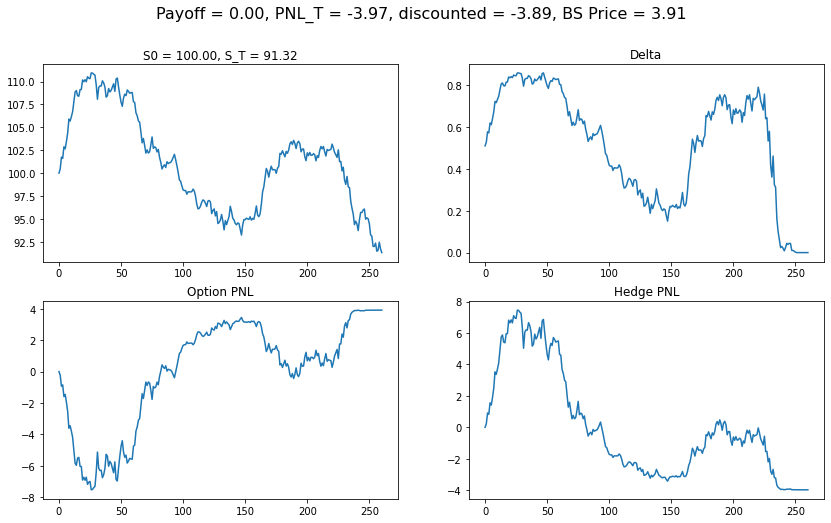

In [46]:
df = simulate_one_path(0.02)

fig, axs = plt.subplots(2, 2)
fig.set_size_inches(14, 8)

row = df.iloc[-1]
tot_pnl = calc_total_pnl(df)

fig.suptitle('Payoff = {:.2f}, PNL_T = {:.2f}, discounted = {:.2f}, BS Price = {:.2f}'.format(
    df.loc[df.index[-1], 'V'],
    tot_pnl,
    tot_pnl * math.exp(-p_r * p_T),
    bs_tv(p_S0, p_K, p_sigma, p_T, p_r, 1)
), fontsize=16)


ax = axs[0, 0]
ax.plot(df.S)
ax.title.set_text('S0 = {:.2f}, S_T = {:.2f}'.format(
    df.loc[0, 'S'], df.loc[df.shape[0] - 1, 'S']
))

ax = axs[0, 1]
ax.plot(df.delta)
ax.title.set_text('Delta')

ax = axs[1, 0]
ax.plot(df.option_pnl.cumsum())
ax.title.set_text('Option PNL')

ax = axs[1, 1]
ax.plot(df.stock_pnl.cumsum())
ax.title.set_text('Hedge PNL')


## Gamma likes big moves

Look at the green line. Everytime there is a big movement in the underlying in either direction we have a big loss.

We lose because we are short gamma. On the other hand we are long theta meaning if there are not much movement in
the market the short option position we have would decay to zero (win for us)

Text(0, 0.5, 'Stock PNL')

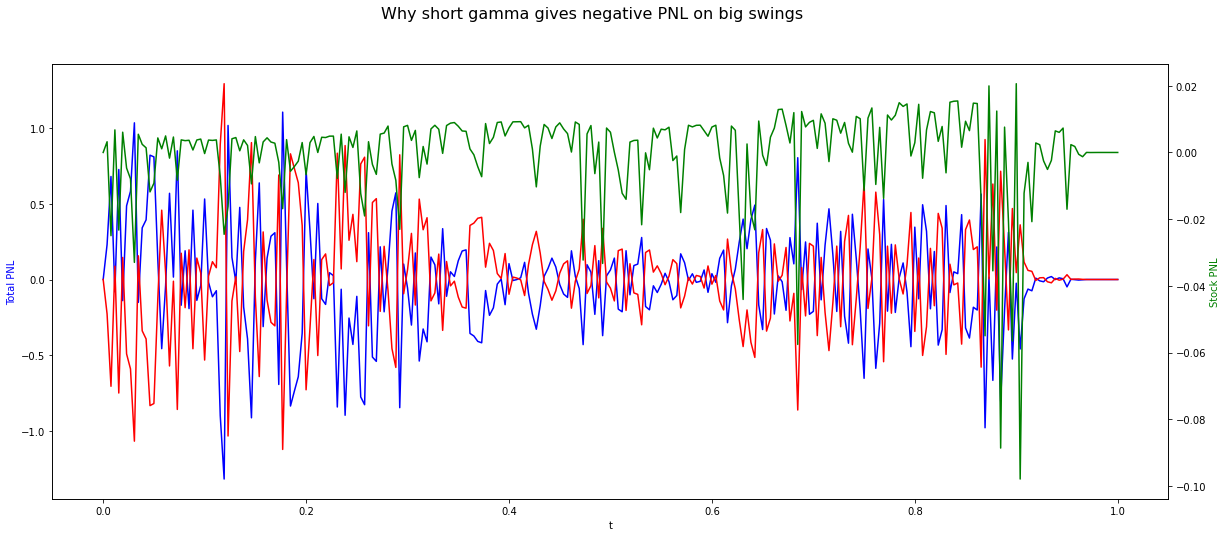

In [47]:
fig, ax1 = plt.subplots()
fig.set_size_inches(20, 8)
fig.suptitle('Why short gamma gives negative PNL on big swings', fontsize=16)
ax1.plot(df.t, df.stock_pnl, 'b-')
ax1.plot(df.t, df.option_pnl, 'r-')
ax1.set_xlabel('t')
ax2 = ax1.twinx()
ax2.plot(df.t, df.pnl, 'g-')

ax1.set_ylabel('Total PNL', color='b')
ax2.set_ylabel('Stock PNL', color='g')

## Let's do some simulation

Instead of looking at one particular scenario, let's run it 1,000 times and see if the hedging cost is indeed the option premium.

In [48]:
def get_port_pnl(r):
    df = simulate_one_path(r)
    return calc_total_pnl(df) * math.exp(-r * p_T)


<lambdifygenerated-11>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return ((-K*cp*((1/2)*erf(0.5*sqrt(2)*cp*(-sqrt(T)*sigma + (0.5*T*sigma**2 + log(S/K))/(sqrt(T)*sigma))) + 1/2) + S*cp*((1/2)*erf(0.5*sqrt(2)*cp*(0.5*T*sigma**2 + log(S/K))/(sqrt(T)*sigma)) + 1/2))*exp(-T*r))
<lambdifygenerated-12>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return ((-0.5*sqrt(2)*K*cp**2*exp(-0.5*cp**2*(-sqrt(T)*sigma + (0.5*T*sigma**2 + log(S/K))/(sqrt(T)*sigma))**2)/(sqrt(pi)*S*sqrt(T)*sigma) + cp*((1/2)*erf(0.5*sqrt(2)*cp*(0.5*T*sigma**2 + log(S/K))/(sqrt(T)*sigma)) + 1/2) + 0.5*sqrt(2)*cp**2*exp(-0.5*cp**2*(0.5*T*sigma**2 + log(S/K))**2/(T*sigma**2))/(sqrt(pi)*sqrt(T)*sigma))*exp(-T*r))
<lambdifygenerated-12>:2: RuntimeWarning: invalid value encountered in double_scalars
  return ((-0.5*sqrt(2)*K*cp**2*exp(-0.5*cp**2*(-sqrt(T)*sigma + (0.5*T*sigma**2 + log(S/K))/(sqrt(T)*sigma))**2)/(sqrt(pi)*S*sqrt(T)*sigma) + cp*((1/2)*erf(0.5*sqrt(2)*cp*(0.5*T*sigma**2 

Time taken 25s


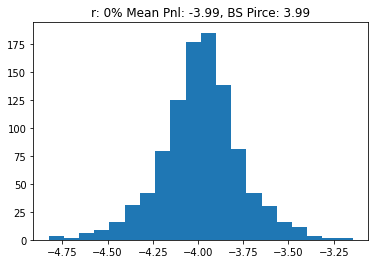

In [49]:
def plot_graph_with_r(p_r, n_sims):
    before = datetime.now()
    port_pnl = [get_port_pnl(p_r) for _ in range(n_sims)]
    avg_pnl = sum(port_pnl) / n_sims
    plt.hist(port_pnl, bins=20)
    bs_price = bs_tv(p_S0, p_K, p_sigma, p_T, p_r, 1)
    plt.title(f'r: {p_r * 100:.0f}% Mean Pnl: {avg_pnl:.2f}, BS Pirce: {bs_price:.2f}')
    print('Time taken {}s'.format((datetime.now() - before).seconds))

plot_graph_with_r(0., 1000)

Time taken 25s


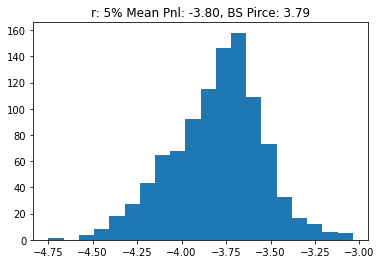

In [50]:
plot_graph_with_r(0.05, 1000)

Looks good, bit this is too slow and boring to wait for if we want to ask more questions.

## Vectorise the delta

Instead we can calculate the delta for every day using vectorisation to speed things up.

We can go from 25s to 0.75s on my machine

First let's write the delta in numpy and check it against the sympy version

In [19]:
def bs_delta(S, K, sigma, r, T):    
    n_steps = S.shape[0]
    d1 = (np.log(S/K) + (0.5 * sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1-sigma*np.sqrt(T)
    DF = np.exp(-r * T)
    return DF * norm.cdf(d1)

dummy_s = np.array([90., 100., 110., 90., 100., 110.])
dummy_t = np.array([1., 1., 0.6, 0.6, 0.3, 0.3])

p_r = 0.02
sym_v = [bs_tv(s, p_K, p_sigma, t, p_r, 1) for s, t in zip(dummy_s, dummy_t)]
sym_delta = [delta(s, p_K, p_sigma, t, p_r, 1) for s, t in zip(dummy_s, dummy_t)]

res_delta = bs_delta(dummy_s, p_K, p_sigma, p_r, dummy_t)

df = pd.DataFrame({
    't': dummy_t,
    'S': dummy_s,
    'delta': res_delta,
    'sym_delta': sym_delta,
})

np.testing.assert_array_almost_equal(df.delta, df.sym_delta)

df

,t,S,delta,sym_delta
0,1.000,90.000,0.155,0.155
1,1.000,100.000,0.510,0.510
2,0.600,110.000,0.887,0.887
3,0.600,90.000,0.092,0.092
4,0.300,100.000,0.508,0.508
5,0.300,110.000,0.956,0.956


## Numpy delta hedging

In [20]:
def simulate_hedging_cost(S0, K, sigma, r, T, mu, n_steps):
    dt = 1. / n_steps
    dW = np.random.normal((mu - 0.5 * sigma ** 2) * dt,
        math.sqrt(dt) * sigma, n_steps-1)
    dW = np.insert(dW, 0, 0)

    S = S0 * np.exp(dW.cumsum())
    prev_S = np.roll(S, 1)

    t = T - np.linspace(0, 1-dt, n_steps-1)
    
    S_T = S[-1]
    V_T = max(S_T - K, 0)    
    delta = bs_delta(S[:-1], K, sigma, r, t)
    delta = np.append(delta, 0.)
    
    pos = delta
    pos[-1] = 0   
    prev_pos = np.roll(pos, 1)
    prev_pos[0] = 0

    pos_pnl = prev_pos * (S - prev_S)
    pos_pnl[0] = 0.
    return pos_pnl.sum() - V_T
    
n_steps = 260
p_r = 0.
p_mu = 0.
simulate_hedging_cost(p_S0, p_K, p_sigma, p_r, p_T, p_mu, n_steps)

-4.230757562475581

## Plotting numpy hedging

Time taken 0.47s


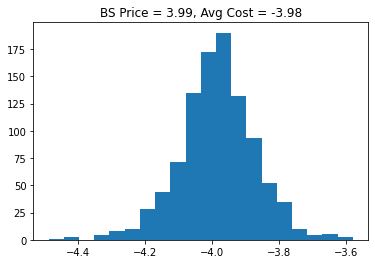

In [21]:
def plot_sims(r, sigma, S0, mu=0., n_steps=1000):
    before = datetime.now()
    n_sims = 1000
    DF = math.exp(-r * p_T)
    all_costs = [simulate_hedging_cost(S0, p_K, sigma, r, p_T, mu, n_steps) * DF for _ in range(n_sims)]
    avg_cost = sum(all_costs) / n_sims
    plt.hist(all_costs, bins=20)
    plt.title('BS Price = {:.2f}, Avg Cost = {:.2f}'.format(
        bs_tv(S0, p_K, sigma, p_T, r, 1),
        avg_cost
    ))
    
    time_taken = (datetime.now() - before)
    print('Time taken {}.{}s'.format(time_taken.seconds, int(time_taken.microseconds / 1e4)))
    
plot_sims(0., 0.1, 100.)

What if we set $r = 0.05$

Time taken 0.48s


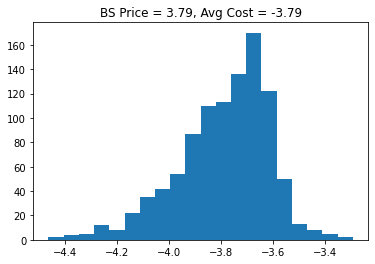

In [22]:
plot_sims(0.05, 0.1, 100.)

What if we set $mu = 0.08$

This is an interesting scenario as it shows that pricing under risk neutral drift works even if reality has a different dift.

Time taken 0.47s


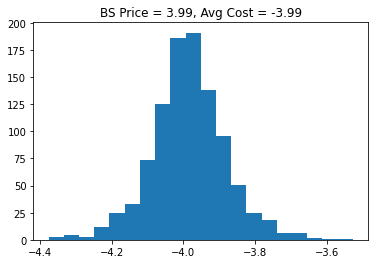

In [23]:
plot_sims(0., 0.1, 100., mu=0.05)

Now we have $r = 0.02$ and $\sigma = 0.2$

See how it is now skewed

Time taken 0.47s


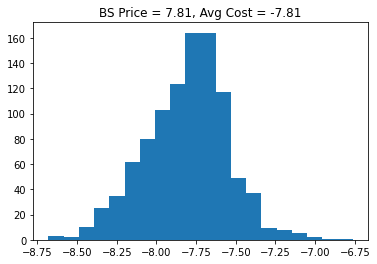

In [24]:
plot_sims(0.02, 0.2, 100.)

Set $S_0 = 110$ i.e. in the money

Time taken 0.47s


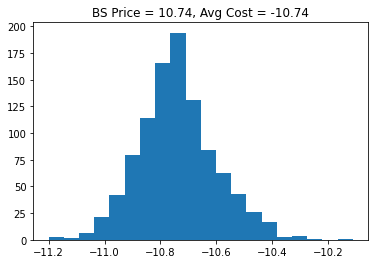

In [25]:
plot_sims(0.02, 0.1, 110.)

Set S_0 = 90 i.e. out of money

Time taken 0.47s


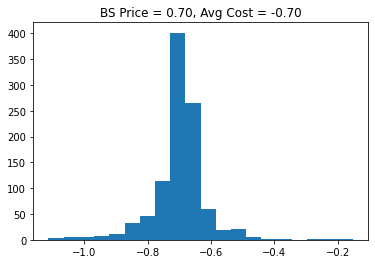

In [26]:
plot_sims(0.02, 0.1, 90.)

There are much we can learn from looking at the hedging cost as we change different parameters.

In the next section, we would setup some distributed compute to run more simulation and get more insight.